In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from igraph import *
from tqdm import tqdm_notebook
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi']=300

def degree_distribution(vk):
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [2]:
def degree_distribution_hashed(arr):
    maxk = int(np.max(arr))
    kvalues = {k:0 for k in range(0, maxk+1)}
    for k in arr:
        try:
            kvalues[k] += 1
        except:
            kvalues[k] = 1
    ks, Pk = [], []
    for key in sorted(kvalues.keys()):
        ks.append(key)
        Pk.append(np.true_divide(kvalues[key],sum(list(kvalues.values()))))

    return ks,Pk

In [3]:
op_text = pd.read_csv('../../Data/intermediate/op_liwc_input.csv')
op_text = op_text.dropna(subset=['op-text'])

In [4]:
op_map = dict(op_text[['conversation_id', 'op-username']].values)

In [5]:
utterances = pd.read_csv('../../Data/intermediate/utterances_delta.csv')
utterances = utterances[utterances.speaker!='DeltaBot']
others_delta = []
awarded_delta = []
counter = 0
for idx, row in tqdm_notebook(utterances.iterrows()):
    try:
        if ("∆" or '&amp;#8710' in str(row['text'])) and (row['speaker'] == op_map[row['conversation_id']]):
            awarded_delta.append(1)
        else:
            awarded_delta.append(0)

        if ("∆" or '&amp;#8710' in str(row['text'])) and (row['speaker'] != op_map[row['conversation_id']]):
            others_delta.append(1)
        else:
            others_delta.append(0)
    except:
        awarded_delta.append(0)
        others_delta.append(0)
        counter+=1
utterances['op_awards_delta'] = awarded_delta
utterances['others_award_delta'] = others_delta


0it [00:00, ?it/s]

In [6]:
# Count how many unique comments in each conversation
utterances[['conversation_id',
            'id']].groupby('conversation_id').agg('count').reset_index().describe()

,id
count,3051.000
mean,93.003
std,110.595
min,11.000
25%,36.000
50%,57.000
75%,98.000
max,1354.000


In [7]:
# Count how many unique speakers in each conversation
utterances[['conversation_id',
            'speaker',
            'id']].groupby(['conversation_id', 
                            'speaker']).agg('count').reset_index()[['conversation_id',
                                                                    'speaker']].groupby('conversation_id').agg('count').reset_index().describe()


,speaker
count,3051.000
mean,37.693
std,41.943
min,11.000
25%,16.000
50%,23.000
75%,38.000
max,429.000


In [8]:
C_all = len(utterances)
print (f'Number of comments = {C_all}')
Speakers_all = utterances.speaker.nunique()
print (f'Number of speakers = {Speakers_all}')
op_delta = len(utterances[utterances["op_awards_delta"]==1])
print(f'Number of comments that receive a delta from OP = {op_delta} ({op_delta/C_all*100:.3f}%)')
other_delta = len(utterances[utterances["others_award_delta"]==1])
print(f'Number of comments that receive a delta from other challengers = {other_delta} ({other_delta/C_all*100:.3f}%)')




Number of comments = 283751
Number of speakers = 34907
Number of comments that receive a delta from OP = 44814 (15.793%)
Number of comments that receive a delta from other challengers = 238634 (84.100%)


In [9]:
# Whether or not a conversation has opinion change
delta_conv_df = utterances[['conversation_id', 'op_awards_delta']].groupby('conversation_id').agg('max').reset_index()
print (f'Deltas awarded in {delta_conv_df.op_awards_delta.sum()} conversations ({delta_conv_df.op_awards_delta.sum()/len(delta_conv_df)*100:.3f}%).')
# Conversations that have opinion change
opinion_change = delta_conv_df[delta_conv_df['op_awards_delta']==1]['conversation_id'].values
comments_before_delta, comments_after_delta = [], []
for conversation in tqdm_notebook(opinion_change):
    cut_off_time = utterances[utterances.op_awards_delta==1]['timestamp'].values[0]
    conversation_df = utterances[utterances.conversation_id==conversation]
    comments_before_delta.append(len(conversation_df[conversation_df.timestamp<cut_off_time]))
    comments_after_delta.append(len(conversation_df[conversation_df.timestamp>cut_off_time]))
print(f'Average number of comments before delta = {np.mean(comments_before_delta)} (std={np.std(comments_before_delta)})')
print(f'Average number of comments after delta = {np.mean(comments_after_delta)} (std={np.std(comments_after_delta)})')



Deltas awarded in 3046 conversations (99.836%).


  0%|          | 0/3046 [00:00<?, ?it/s]

Average number of comments before delta = 64.08798424162836 (std=102.88633360599226)
Average number of comments after delta = 28.837491792514772 (std=72.84134568350595)


In [10]:
delta_conv_df[delta_conv_df.op_awards_delta==0]

,conversation_id,op_awards_delta
10,t3_19ciml,0
14,t3_19rkir,0
89,t3_1cxzjz,0
113,t3_1dhwj4,0
129,t3_1ds4zg,0


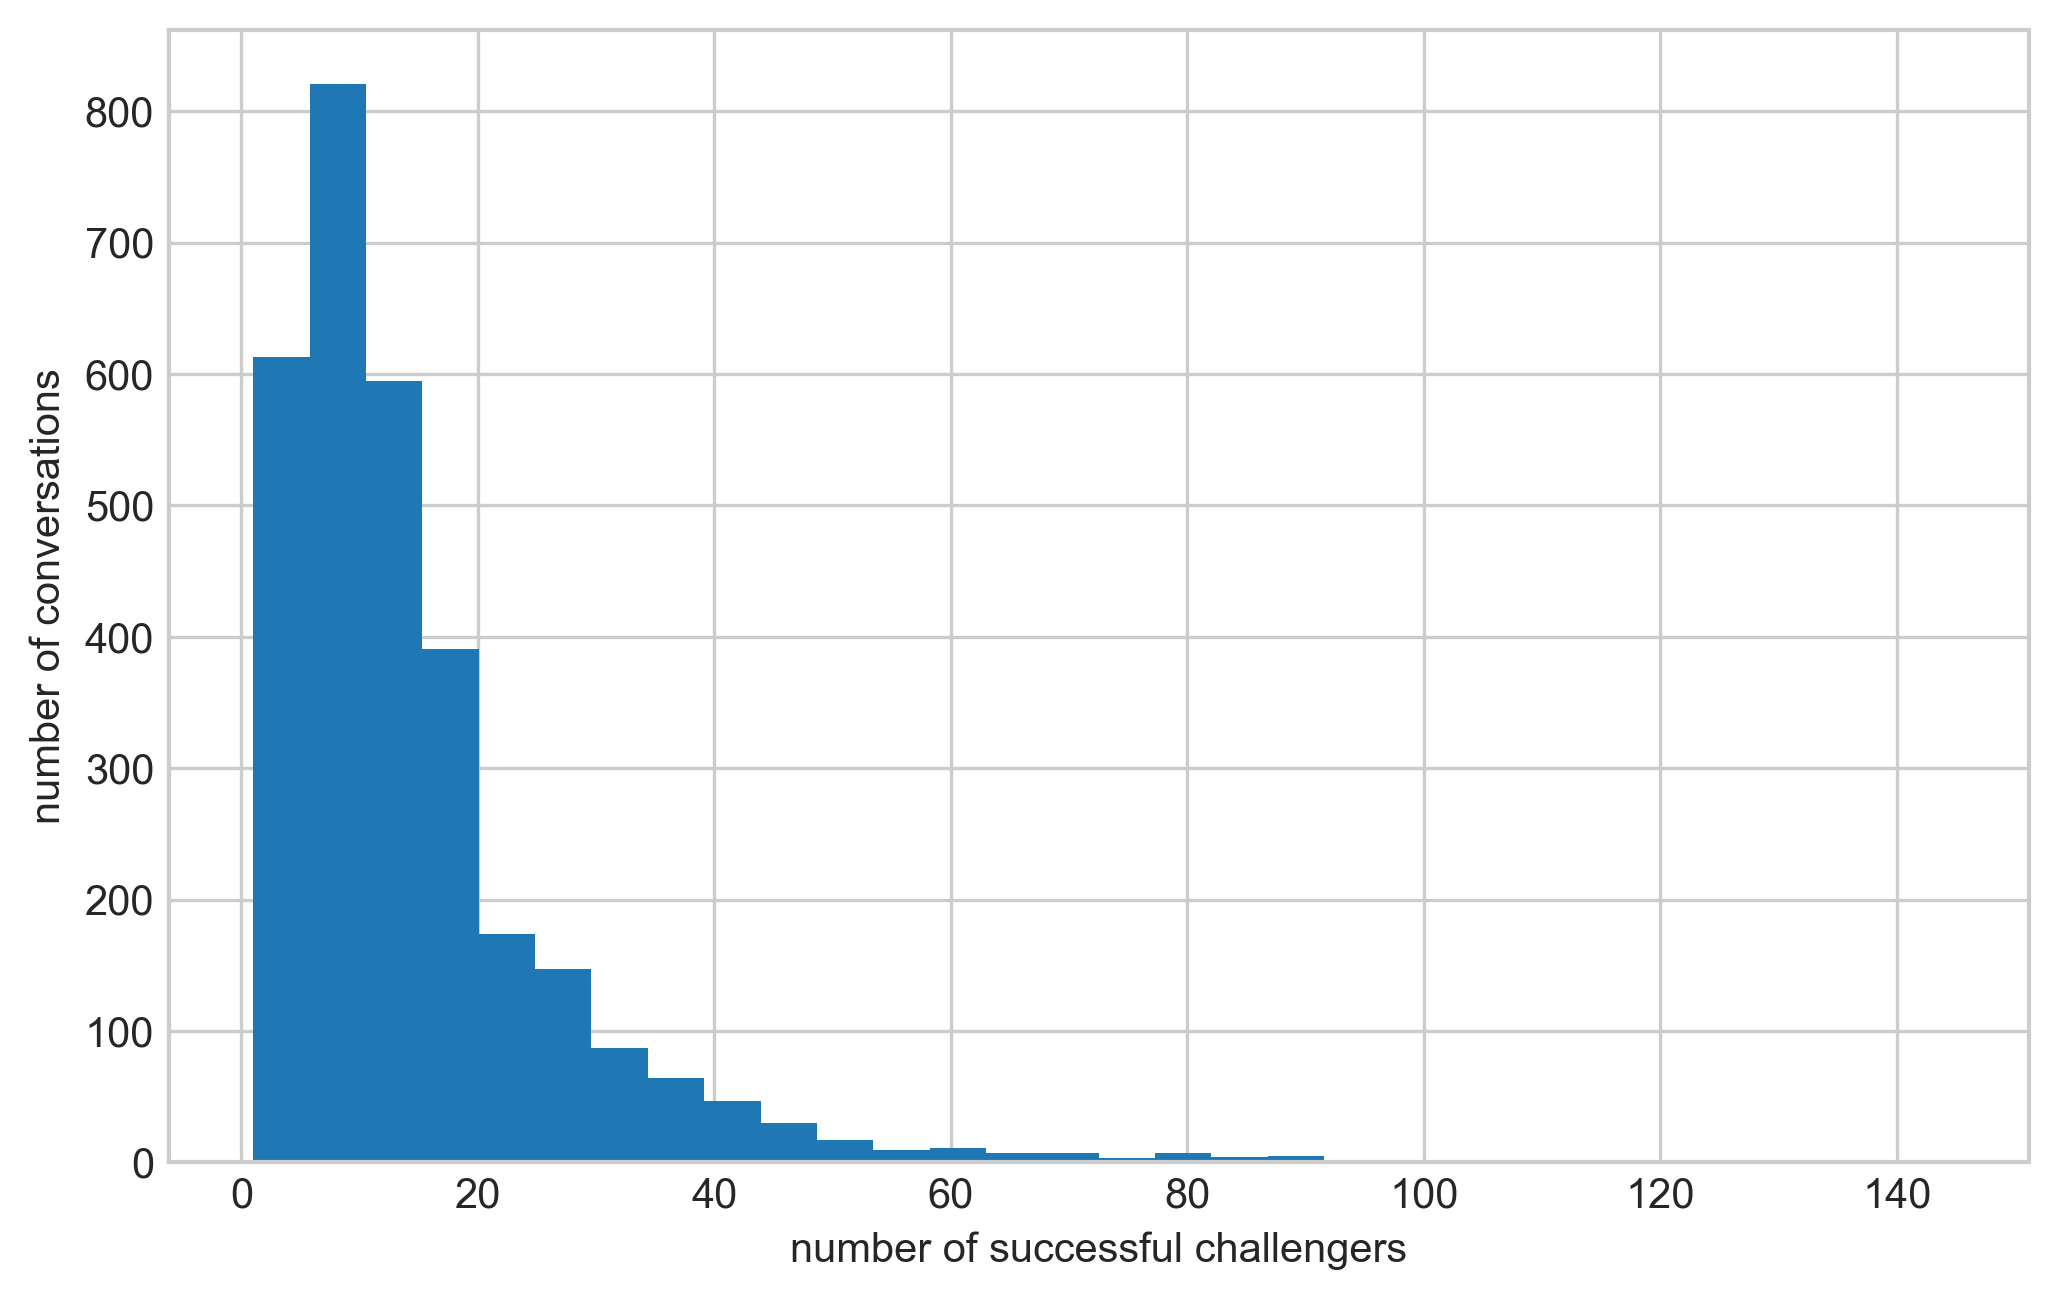

In [11]:
fig, ax = plt.subplots( figsize=(8,5), dpi=300)
utterances[utterances.conversation_id.isin(opinion_change)][['conversation_id', 'op_awards_delta']].groupby('conversation_id').agg('sum').reset_index()['op_awards_delta'].hist(bins=30);
plt.xlabel('number of successful challengers')
plt.ylabel('number of conversations')
plt.show()


In [12]:
colors = {0:'grey',
          1: '#8272B2'}

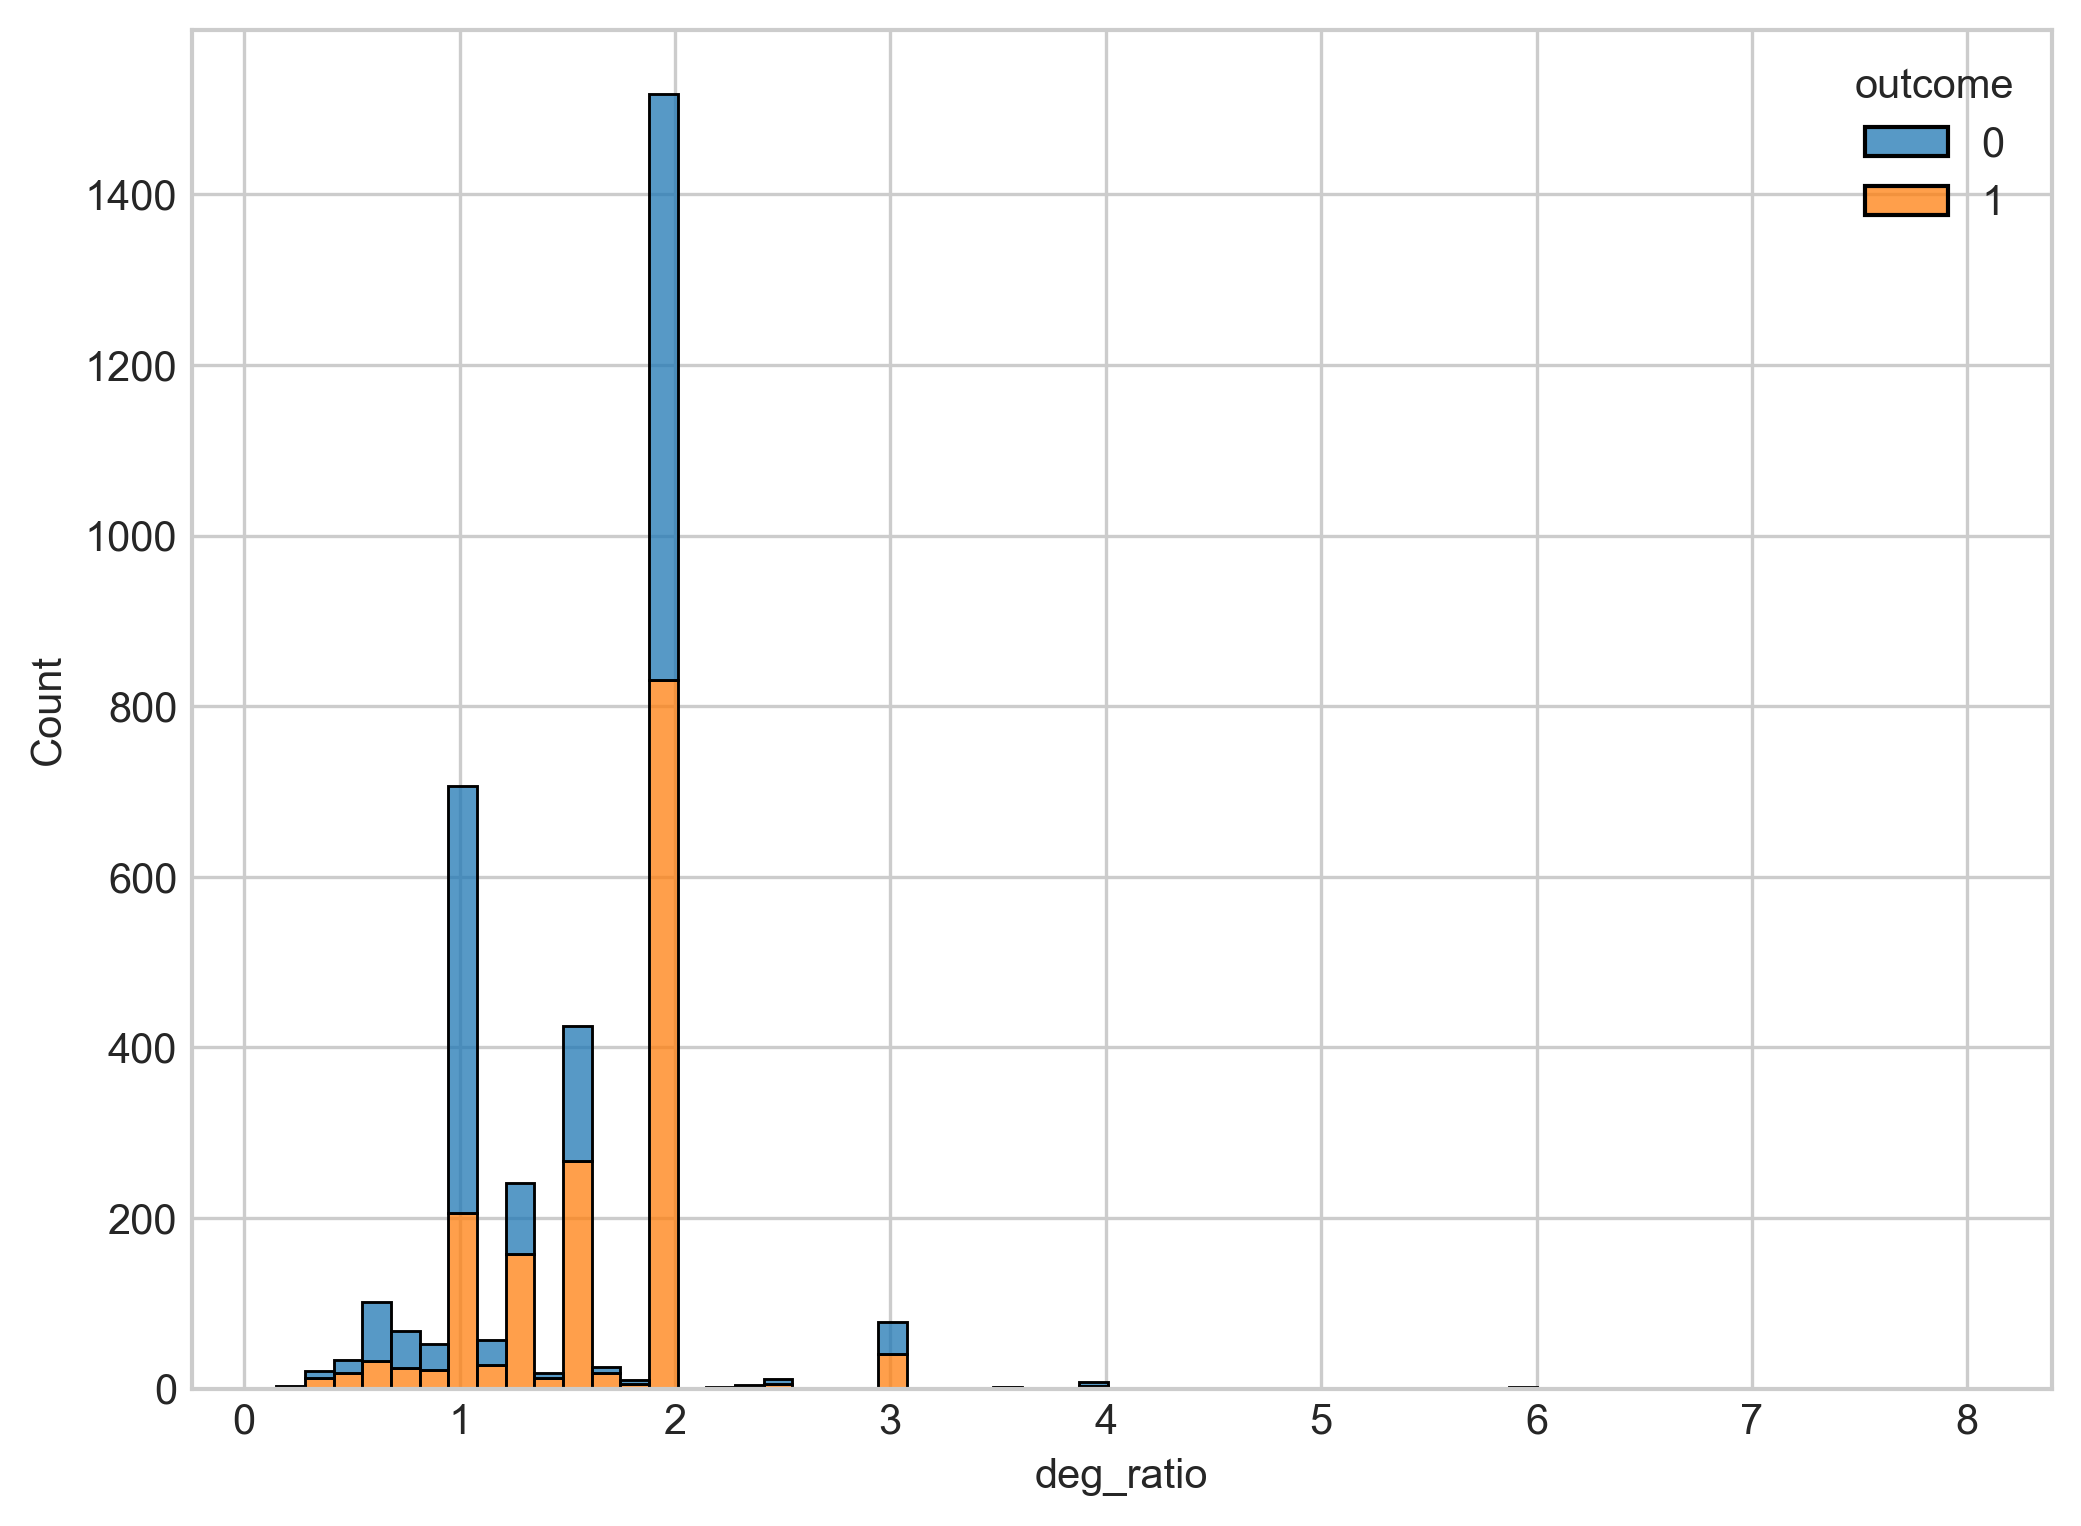

In [13]:
matched_pairs = pd.read_csv('../../Data/chenhao_pairs.csv')
fig, ax = plt.subplots( figsize=(8,6), dpi=300)
sns.histplot(data=matched_pairs, x='deg_ratio', hue='outcome', multiple="stack");


In [14]:
ks, Pk = degree_distribution_hashed(matched_pairs.deg_ratio.values)

In [15]:
len(Pk)

80

In [16]:
# matched_pairs = pd.read_csv('../Data/matched_after.csv')
# fig, ax = plt.subplots( figsize=(8,6), dpi=300)
# s = 20
# sns.histplot(data=matched_pairs, bins=20, x='deg_ratio', hue='outcome', element="step")# multiple="stack", pall);
# plt.ylabel('Number of challengers', fontsize=s)
# plt.xlabel('Degree ratio \n(out-degree / in-degree)', fontsize=s)
# plt.xticks(fontsize=s)
# plt.yticks(fontsize=s)
# plt.show()

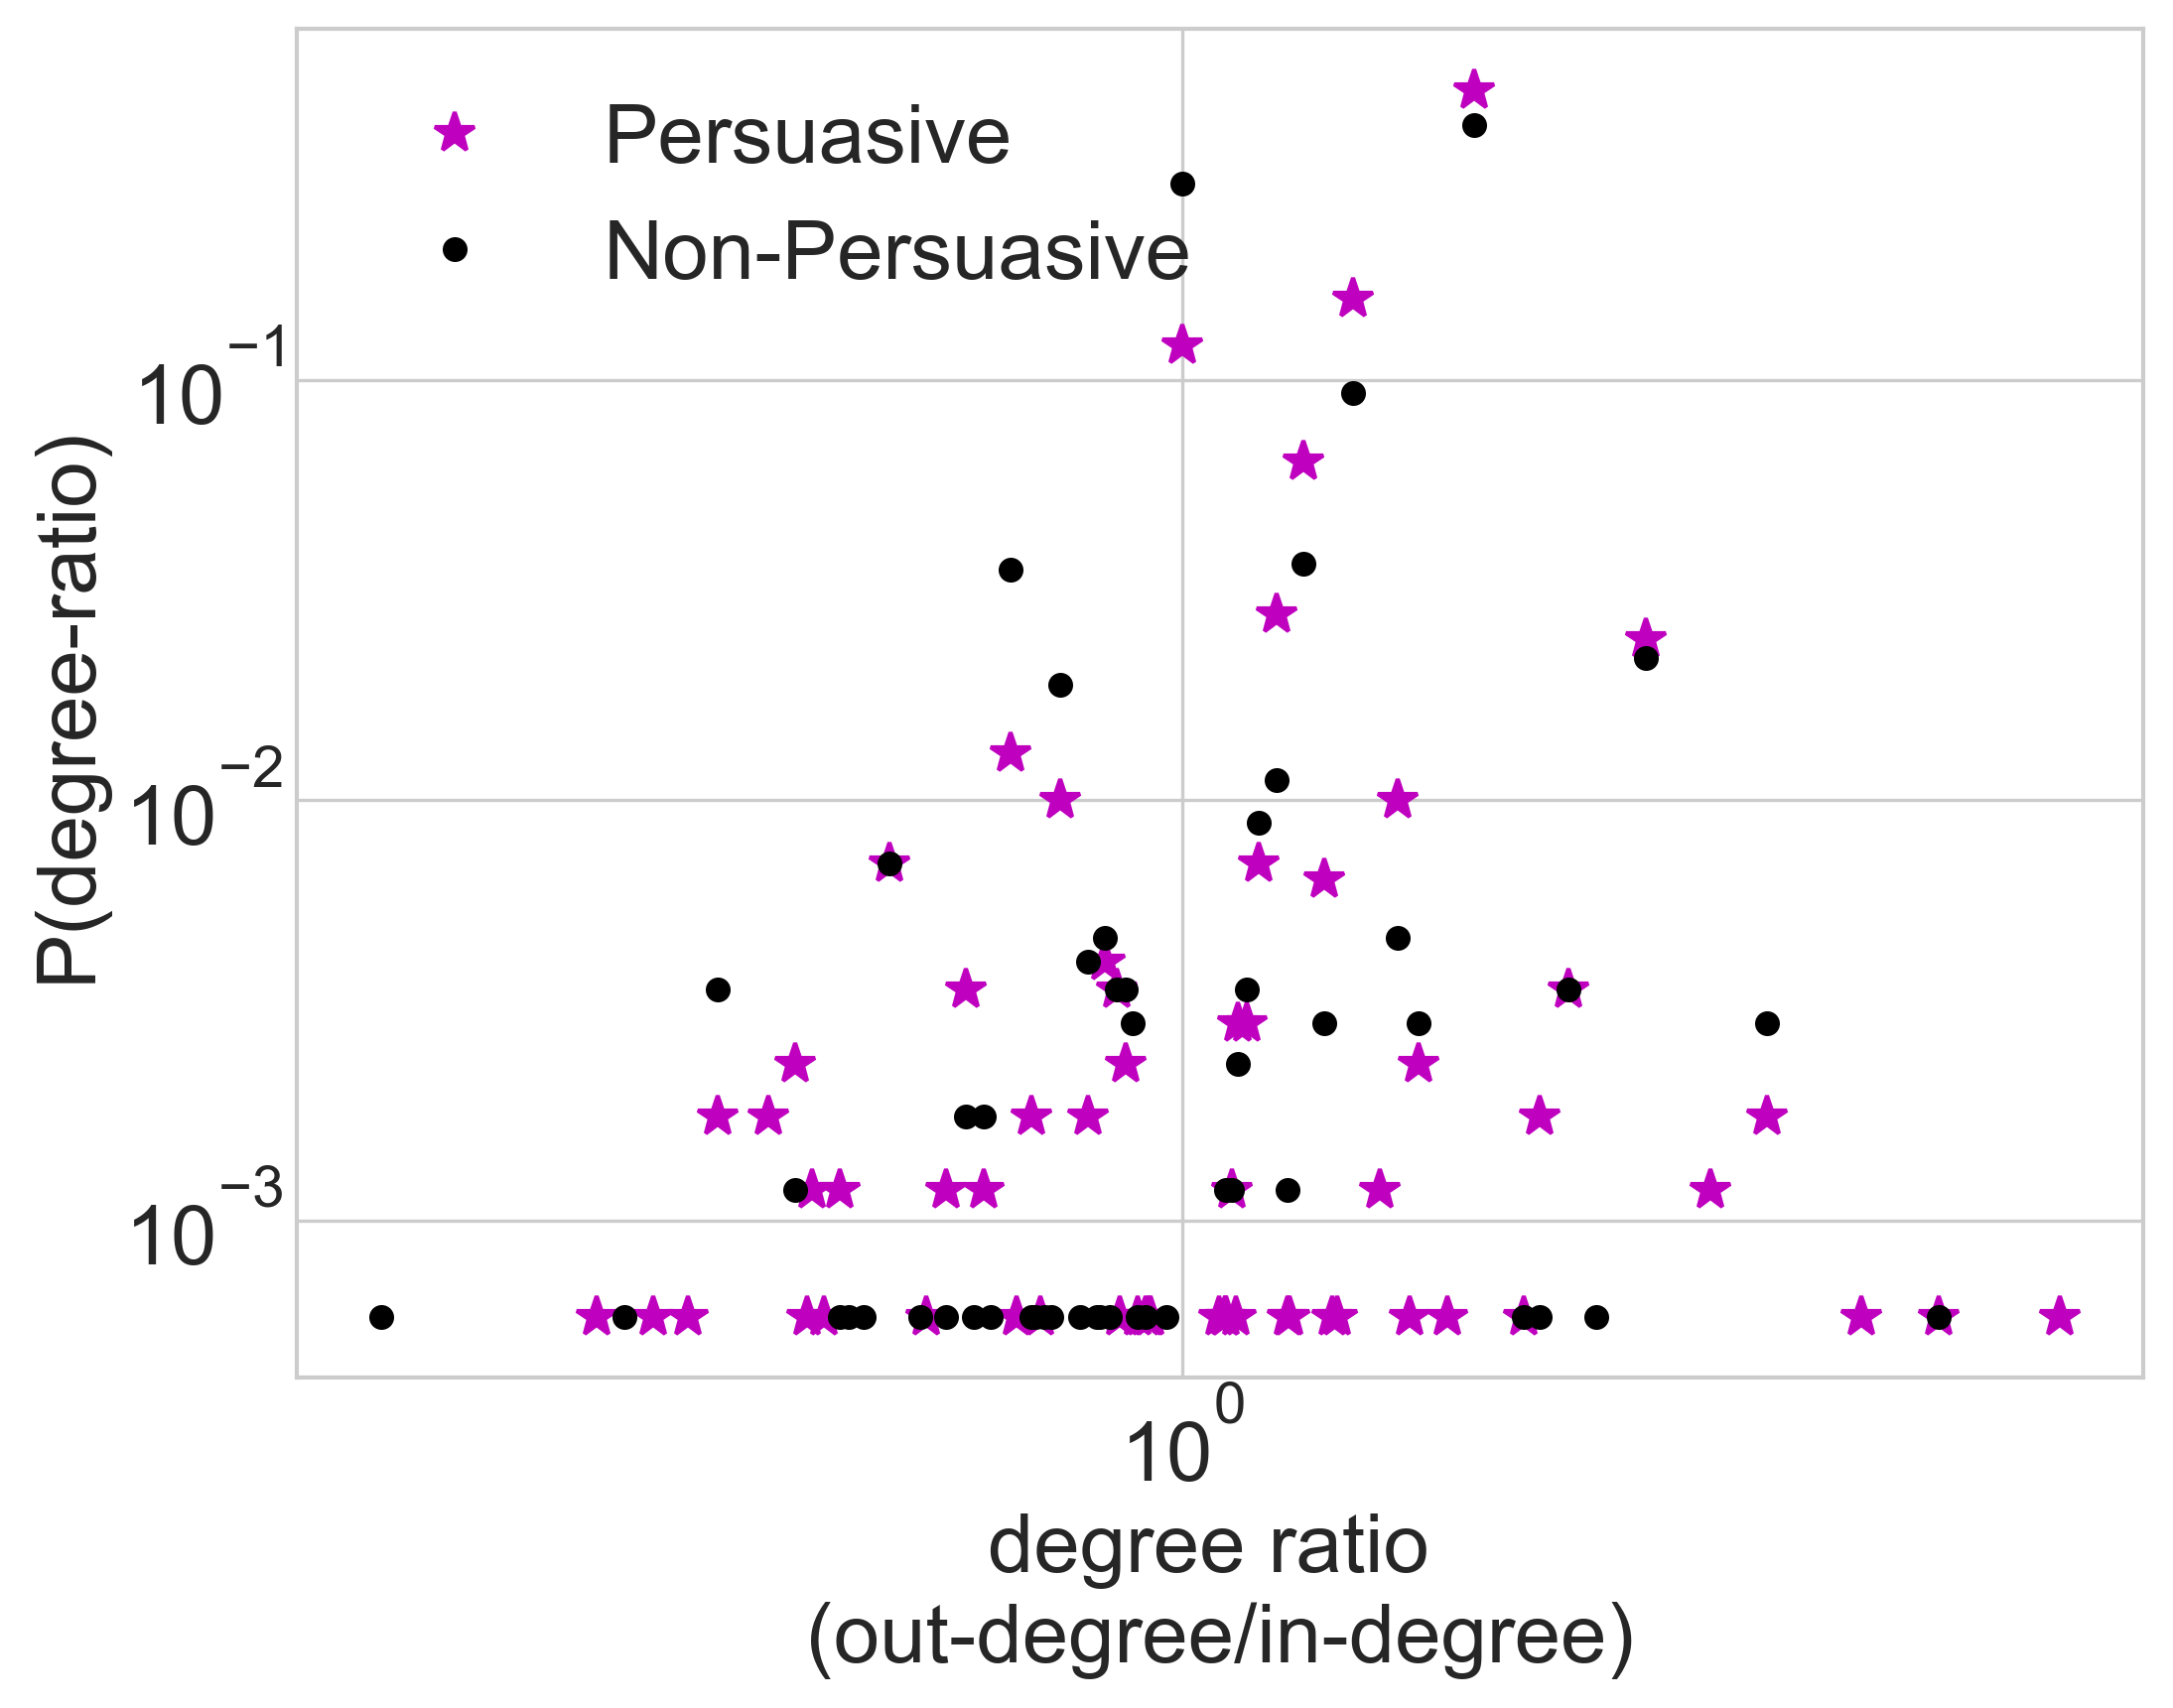

In [17]:
s=20

fig, ax = plt.subplots( figsize=(8,6), dpi=300)
pos_vk = matched_pairs[matched_pairs.outcome==1]['deg_ratio']
ks, Pk = degree_distribution_hashed(pos_vk)
plt.loglog(ks,Pk, 'm*', alpha=1, markersize=s/2, base=10, label='Persuasive')
neg_vk = matched_pairs[matched_pairs.outcome==0]['deg_ratio']
ks, Pk = degree_distribution_hashed(neg_vk)
plt.loglog(ks,Pk,'k.', alpha=1, markersize=s/2, base=10, label='Non-Persuasive')
plt.xlabel("degree ratio \n(out-degree/in-degree)", fontsize=s)
plt.ylabel("P(degree-ratio)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)
plt.legend(loc=2, fontsize=s)
plt.show()

### Network Summary

In [18]:
graph_map = {}
for conversation in tqdm_notebook(utterances.conversation_id.unique()):
    # conversation dataframe
    conversation_df = utterances[utterances.conversation_id==conversation]
    # construct conversation network from comments before delta  
    edges = conversation_df[['speaker', 'reply_to_speaker']].to_numpy()

    vertices = np.unique(edges.flatten())
    
    g = Graph(directed=True)
    g.add_vertices(vertices)
    g.add_edges(edges)

    graph_map[conversation] = g

  0%|          | 0/3051 [00:00<?, ?it/s]

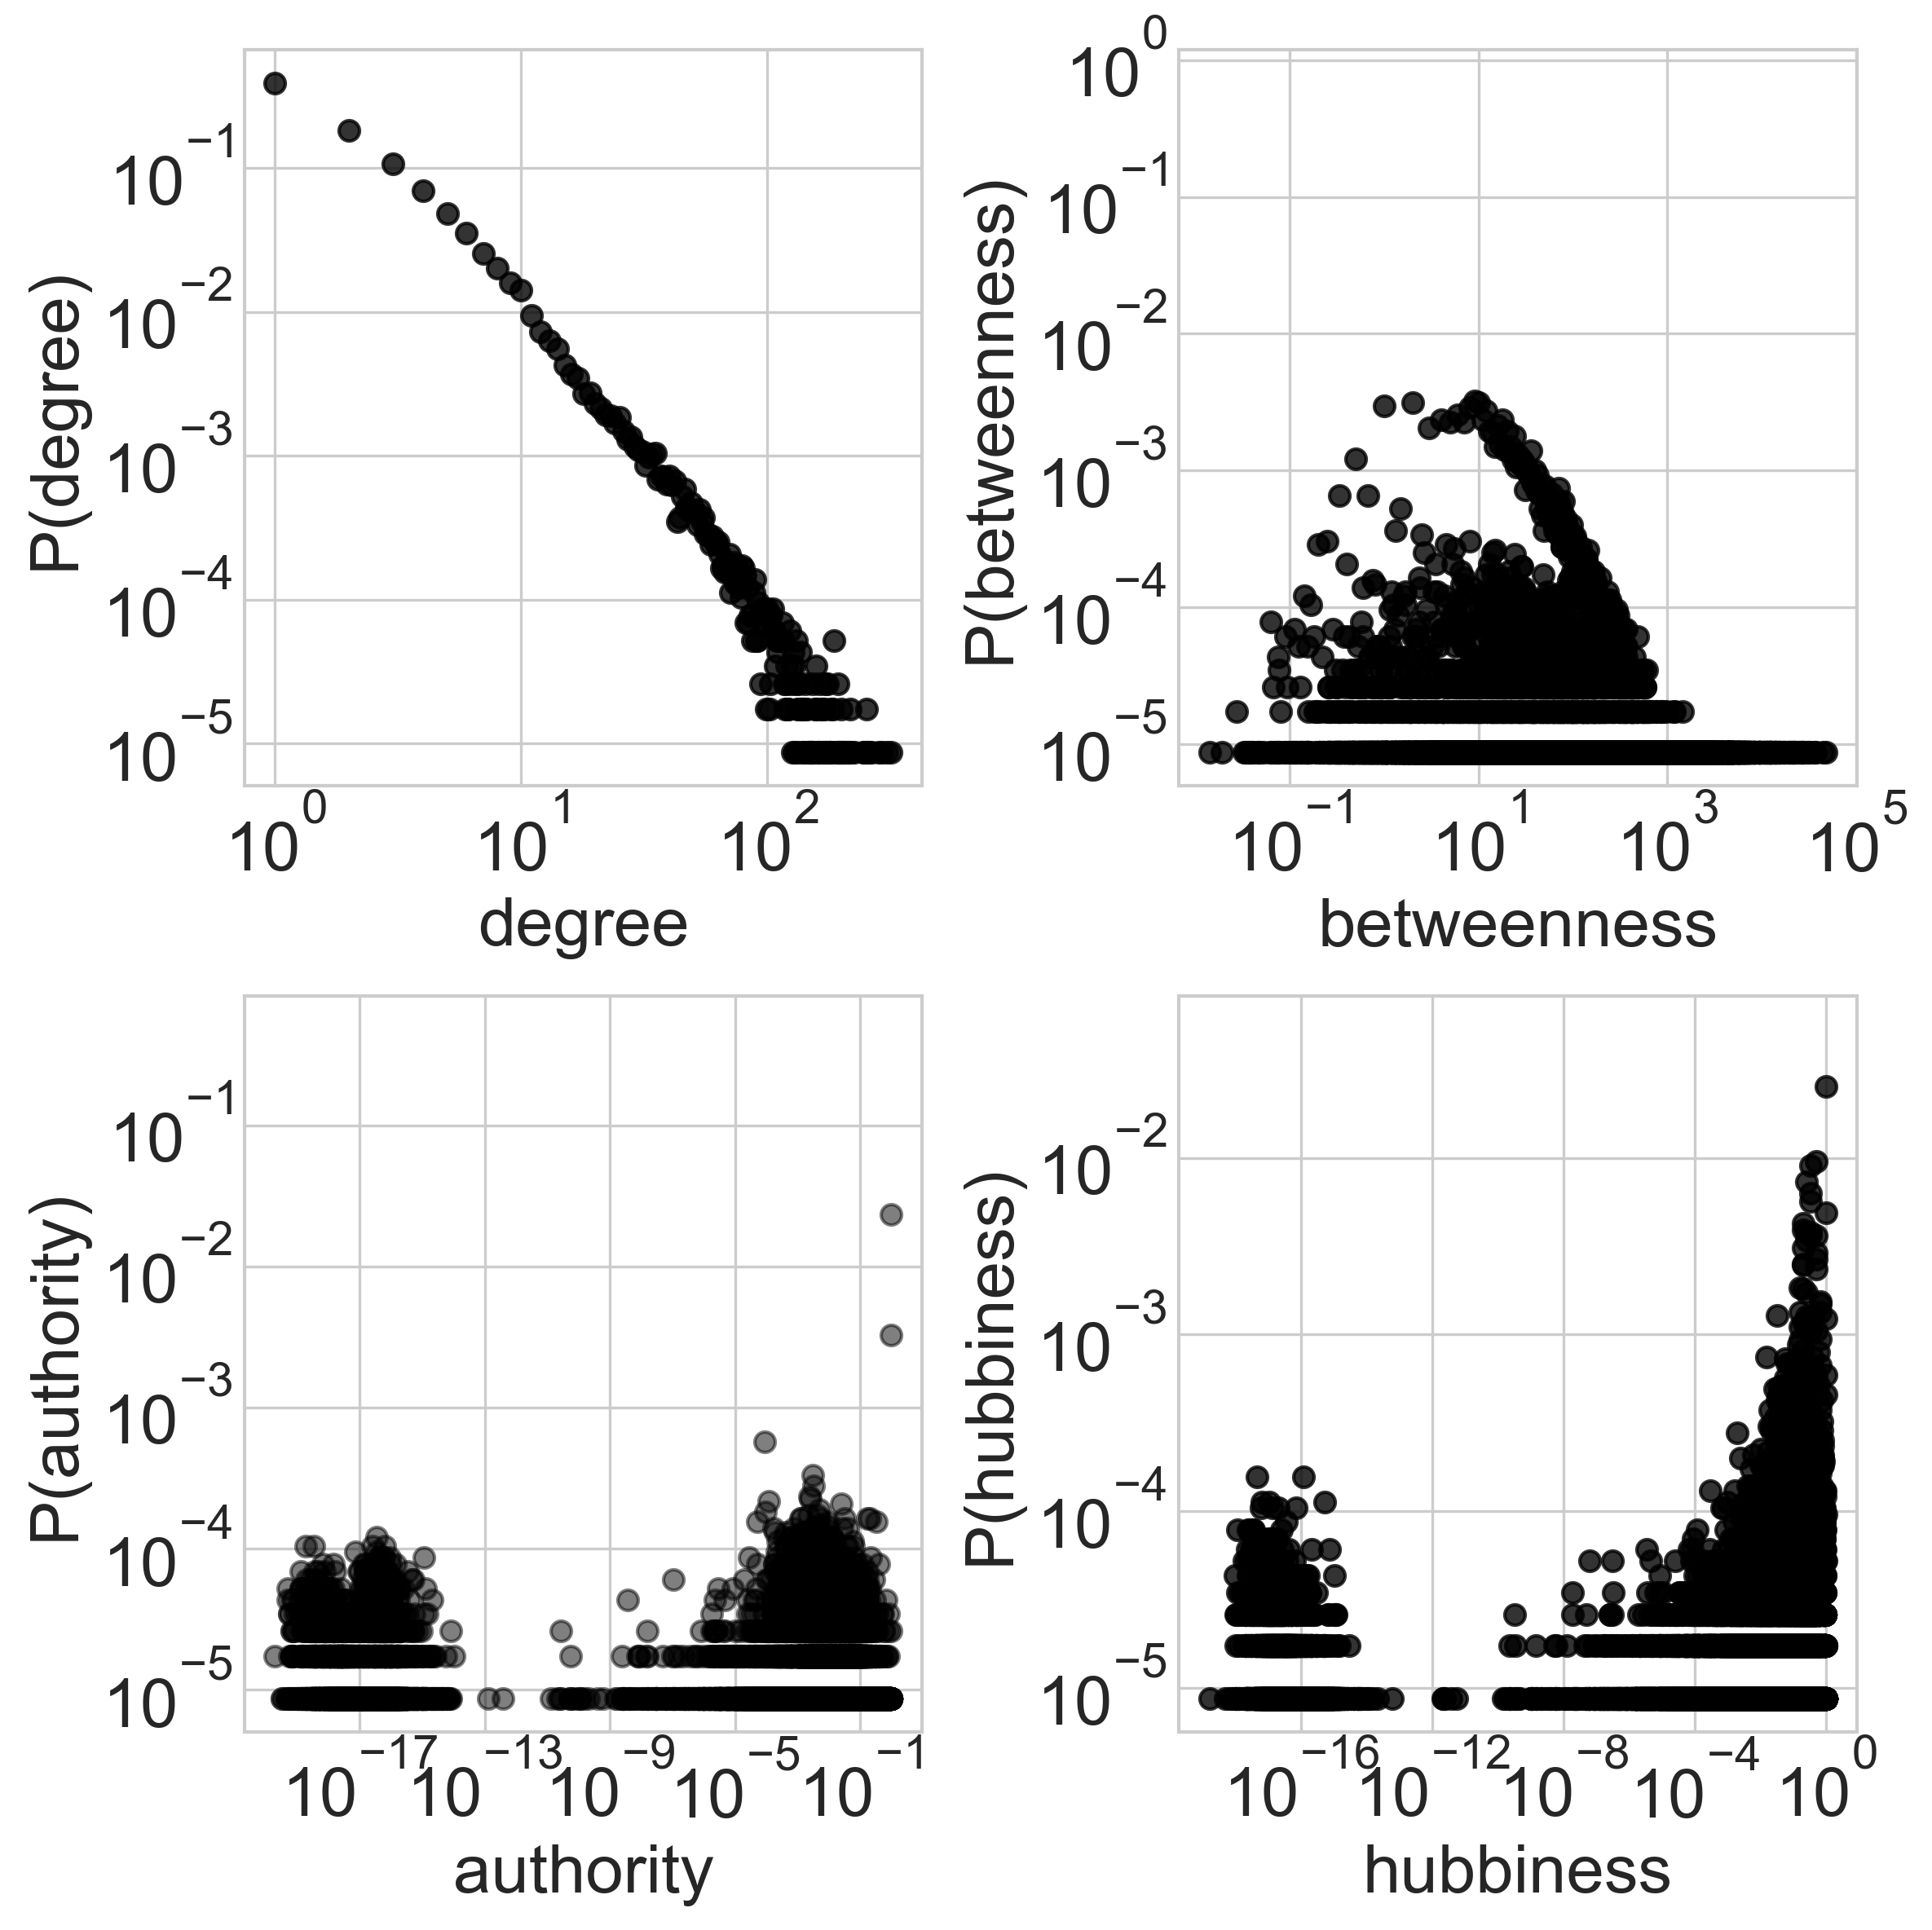

In [19]:
fig, ax = plt.subplots( figsize=(8,8), dpi=300)

plt.subplot(2,2,1)

s=20

vk = []
for k, graph in graph_map.items():
    vk += graph.degree()
ks, Pk = degree_distribution_hashed(vk)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("degree", fontsize=s)
plt.ylabel("P(degree)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)


plt.subplot(2,2,2)

bc = []
for k, graph in graph_map.items():
    bc += graph.betweenness()
ks, Pk = degree_distribution_hashed(bc)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("betweenness", fontsize=s)
plt.ylabel("P(betweenness)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)

plt.subplot(2,2,3)

auth = []
for k, graph in graph_map.items():
    auth += graph.authority_score(scale=True)
ks, Pk = degree_distribution_hashed(auth)
plt.loglog(ks,Pk,'ko', alpha=.5, base=10)
plt.xlabel("authority", fontsize=s)
plt.ylabel("P(authority)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)


plt.subplot(2,2,4)

hub = []
for k, graph in graph_map.items():
    hub += graph.hub_score(scale=True)
ks, Pk = degree_distribution_hashed(hub)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("hubbiness", fontsize=s)
plt.ylabel("P(hubbiness)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)

plt.tight_layout()
plt.show(True)

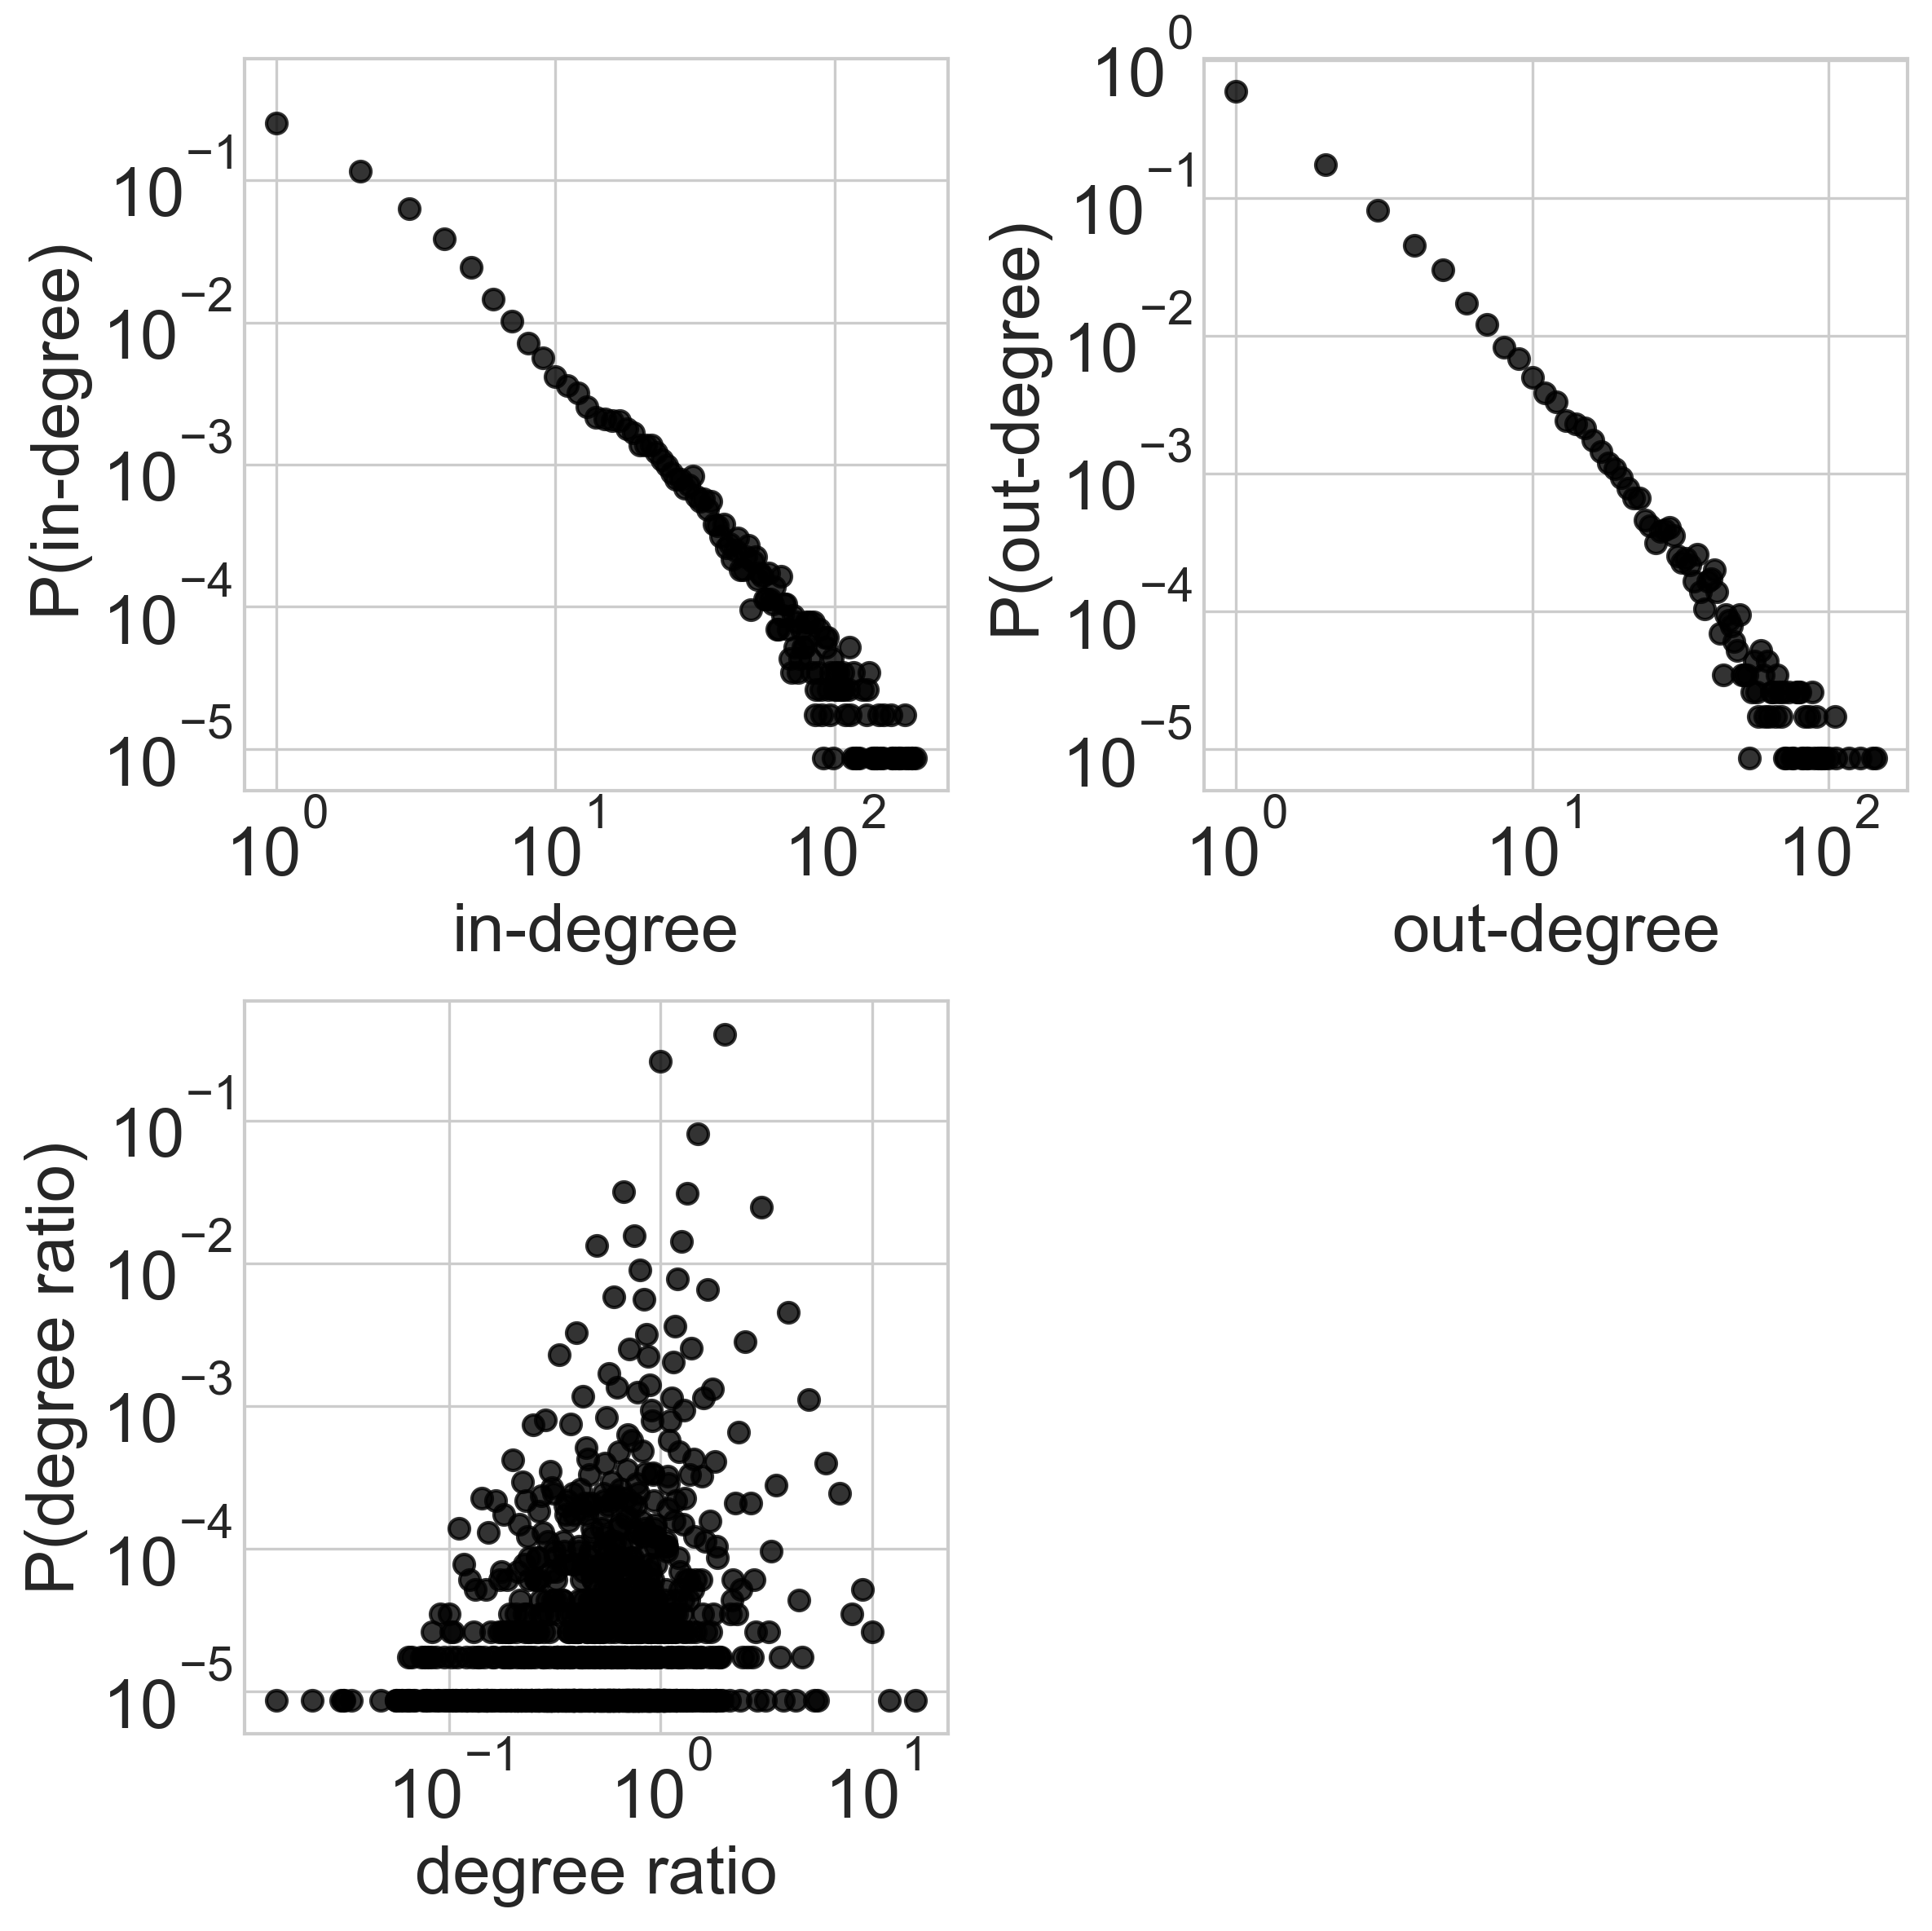

In [20]:
fig, ax = plt.subplots( figsize=(8,8), dpi=300)

plt.subplot(2,2,1)

s=20

indeg = []
for k, graph in graph_map.items():
    indeg += graph.indegree()
ks, Pk = degree_distribution_hashed(indeg)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("in-degree", fontsize=s)
plt.ylabel("P(in-degree)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)


plt.subplot(2,2,2)

outdeg = []
for k, graph in graph_map.items():
    outdeg += graph.outdegree()
ks, Pk = degree_distribution_hashed(outdeg)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("out-degree", fontsize=s)
plt.ylabel("P(out-degree)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)

plt.subplot(2,2,3)

deg_ratio = []
for i, o in zip(indeg,outdeg):
    deg_ratio.append(np.true_divide(o+1,i+1))
ks, Pk = degree_distribution_hashed(deg_ratio)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("degree ratio", fontsize=s)
plt.ylabel("P(degree ratio)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)

plt.tight_layout()
plt.show(True)

In [21]:
delta_dfs = utterances[['conversation_id', 
            'speaker', 
            'op_awards_delta', 
            'others_award_delta']].groupby('speaker').agg('sum').reset_index()

delta_dfs


,speaker,op_awards_delta,others_award_delta
0,--_0,0,1
1,--thatguy,0,1
2,-10-5-19-20-5-18-,0,1
3,-1point,0,1
4,-5m,0,1
...,...,...,...
34902,zzork_,0,2
34903,zzresolutezz,0,1
34904,zzscherp,0,4
34905,zzzev,0,8


In [22]:
delta_dfs.op_awards_delta.max(), delta_dfs.others_award_delta.max()

(308, 18458)

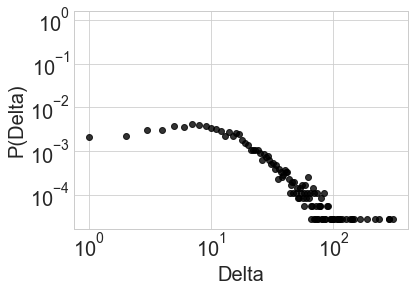

In [23]:
ks, Pk = degree_distribution(delta_dfs.op_awards_delta.values)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("Delta", fontsize=s)
plt.ylabel("P(Delta)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)
plt.show()

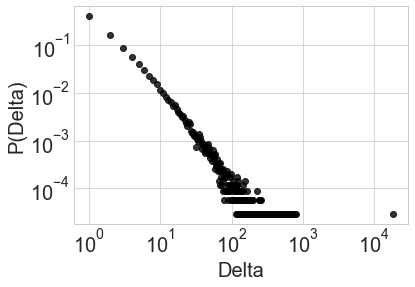

In [24]:
ks, Pk = degree_distribution(delta_dfs.others_award_delta.values)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("Delta", fontsize=s)
plt.ylabel("P(Delta)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s)
plt.show()

In [25]:
delta_dfs[delta_dfs.op_awards_delta>0]

,speaker,op_awards_delta,others_award_delta
16,-Jamerican,32,16
30,-SoItGoes,1,5
69,0826,4,0
85,0sirisdev,8,0
105,10792643,13,0
...,...,...,...
34805,zijw,7,0
34822,zjm555,14,47
34853,zonabakvish,20,0
34889,zuugzwang,3,0


In [26]:
delta_dfs[(delta_dfs.op_awards_delta>0) & (delta_dfs.others_award_delta>0)]

,speaker,op_awards_delta,others_award_delta
16,-Jamerican,32,16
30,-SoItGoes,1,5
135,13104598210,34,5
141,14flema,5,1
148,16tonweight,25,6
...,...,...,...
34749,zectofrazer,11,2
34758,zefod,15,2
34773,zeperf,20,19
34822,zjm555,14,47


In [ ]:
hub = []
for k, graph in graph_map.items():
    hub += graph.hub_score(scale=True)
ks, Pk = degree_distribution_hashed(hub)
plt.loglog(ks,Pk,'ko', alpha=.8, base=10)
plt.xlabel("hubbiness", fontsize=s)
plt.ylabel("P(hubbiness)", fontsize=s)
plt.yticks(size=s)
plt.xticks(size=s);